In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3
from matplotlib.colors import LogNorm
from matplotlib import cm
import matplotlib.animation as animation
sns.set_style('whitegrid')

In [2]:
class Adam(object):
    def __init__(self, lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-8):
        """
        Use recommended parameters from paper of Adam: 
            -- https://arxiv.org/abs/1412.6980
        """
        self.lr = lr
        self.beta_1 = beta_1
        self.beta_2 = beta_2
        self.eps = epsilon
        self.iter = 1
    def update(self, params, grads):
        f_param = params.ravel()
        f_grad  = grads.ravel()
        if not hasattr(self, 'ms'):
            self.ms = np.zeros_like(f_param)
            self.vs = np.zeros_like(f_param)
        for i, (x, dx, m, v) in enumerate(zip(f_param, f_grad, self.ms, self.vs)):    
            # Evaluate:
            m = self.beta_1*m + (1-self.beta_1)*dx # m_t = b1*m_t-1 + (1-b1)*g
            mt = m / (1-self.beta_1**self.iter) # m_t_h = m_t / (1-b1^t)
            v = self.beta_2*v + (1-self.beta_2)*(dx**2) # v_t = b2*v_t-1 + (1-b2)*g^2
            vt = v / (1-self.beta_2**self.iter) # v_t_h = v_t / (1-b2^t)
            
            # Update:
            f_param[i] -= self.lr * mt / (np.sqrt(vt) + self.eps) # theta = -lr * m_t_h / (sqrt(v_t_h) + eps)
            self.ms[i] = m # write m_t to memory (update from m_t-1 to m_t)
            self.vs[i] = v # write v_t to memory (update from v_t-1 to v_t)
        self.iter += 1

In [3]:
class Adagrad(object):
    def __init__(self, lr=0.001, decay_rate=0.9, epsilon=1e-8):
        """
        Ref from CS231n:
        http://cs231n.github.io/neural-networks-3
        cache = decay_rate * cache + (1 - decay_rate) * dx**2
        x += - learning_rate * dx / (np.sqrt(cache) + eps)
        """
        self.lr = lr
        self.decay = decay_rate
        self.eps = epsilon
    def update(self, params, grads):
        f_param = params.ravel()
        f_grad  = grads.ravel()
        if not hasattr(self, 'cache'):
            self.cache = np.zeros_like(f_param)
        for i, (x, dx, c) in enumerate(zip(f_param, f_grad, self.cache)):
            # Evaluate:
            c_t = self.decay * c + (1 - self.decay) * dx**2
            
            # Update:
            f_param[i] -= self.lr * dx / (np.sqrt(c_t) + self.eps) 
            self.cache[i] = c_t # update cache

In [4]:
class Gradient_Descent(object):
    def __init__(self, lr=0.001, decay_rate=0.9, epsilon=1e-8):
        """
        Ref from CS231n:
        http://cs231n.github.io/neural-networks-3
        cache = decay_rate * cache + (1 - decay_rate) * dx**2
        x += - learning_rate * dx / (np.sqrt(cache) + eps)
        """
        self.lr = lr
    def update(self, params, grads):
        f_param = params.ravel()
        f_grad  = grads.ravel()
        for i, (x, dx) in enumerate(zip(f_param, f_grad)):
            f_param[i] -= self.lr * dx

In [5]:
def minimize(x, g_f, iterations=2000, optimizer=None, approximate_gradient=False, f=None, x_eps=1e-8, return_seq=False):
    x = x.copy()
    if return_seq:
        xt = [x.copy()]
        yt = [f(x)]
    for _ in range(iterations):
        if approximate_gradient:
            grad = (f(x+x_eps) - f(x)) / x_eps 
        else:
            grad = g_f(x)
        optimizer.update(x, grad)
        if return_seq:
            xt.append(x.copy())
            yt.append(f(x))
    if return_seq:
        return x, xt, yt
    else:
        return x

In [6]:
# Basic definition of fx funciton
fx_lambda = lambda x: x**4 - 3*(x**2) + 2
# g_fx = lambda x: 4*x**3 - 6*x
def fx(x):
    return np.squeeze(x**4 - 3*(x**2) + 2) # scaler

def g_fx(x):
    ret = np.zeros_like(x)
    ret[...] = 4*x**3 - 6*x
    return ret

# Basic definition of rosenbrock function
rosenbrock_lambda = lambda x1, x2: 100*(x2-x1)**2 + (1-x1)**2
# g_rosenbrock = lambda x1, x2: (202*x1 - 200*x2 - 2, -200*(x1-x2)) # partial_x1, partial_x2
def rosenbrock(x):
    return np.squeeze(100*(x[...,1]-x[...,0])**2 + (1-x[...,0])**2)  # scaler

def g_rosenbrock(x):
    ret = np.zeros_like(x)
    ret[...,0] = 202*x[...,0] - 200*x[...,1] - 2
    ret[...,1] = -200*(x[...,0]-x[...,1])
    return ret

basin_lambda = lambda x, y: np.sin(x**2 + y**2)
def basin(x):
    return np.squeeze(np.sin(x[...,0]**2 + x[...,1]**2))
def g_basin(x):
    ret = np.zeros_like(x)
    ret[...,0] = 2 * x[...,0] * np.cos(x[...,0]**2 + x[...,1]**2)
    ret[...,1] = 2 * x[...,1] * np.cos(x[...,0]**2 + x[...,1]**2)
    return ret


In [7]:
def make_surface(func=rosenbrock_lambda ,xlim=[-5, 5], ylim=[-5, 5], step=0.25):
    X = np.arange(xlim[0], xlim[1], step)
    Y = np.arange(ylim[0], ylim[1], step)
    X, Y = np.meshgrid(X, Y)
    Z = func(X, Y)
    return X, Y, Z

def make_line(func=fx_lambda, xlim=[-5, 5], step=0.25):
    X = np.arange(xlim[0], xlim[1], step)
    Y = func(X)
    return X, Y

def visualize(title_name='Gradient Descent Animation (Adam)' ,filename='test.mp4', fps=30, xs=None, ys=None, f=None, xlim=[-5,5], ylim=[-5,5], step=0.3, skip=10):
    xs = np.asarray(xs[::skip])
    ys = np.asarray(ys[::skip])
    
    if xs.shape[-1]==1: # 2D animation
        fig, ax = plt.subplots(dpi=150)
        ax.set_title(title_name)
        x, y = make_line(func=f, xlim=xlim, step=step)
        line, = ax.plot(x, y)
        point, = ax.plot([], [], 'bo', color='tab:red')
        def animate(i):
            point.set_data(xs[i-1:i] ,ys[i-1:i])
            return line, point,
        def init():
            line.set_ydata(y)
            point.set_data([], [])
            return line, point,
        ani = animation.FuncAnimation(fig, animate, frames=len(xs), init_func=init,
                                   interval=200, blit=True)
        ani.save(filename, fps=fps, extra_args=['-vcodec', 'libx264'])
        plt.close(fig)
    elif xs.shape[-1]==2: # 3D animation
        fig = plt.figure(dpi=150, figsize=(8, 5))
        ax = p3.Axes3D(fig)
        ax.view_init(80, 40)
        
        x, y, z = make_surface(f, xlim=xlim, ylim=ylim, step=step)
        ax.plot_surface(x, y, z, rstride=1, cstride=1, edgecolor='none', alpha=.8, cmap=plt.cm.jet)

        line, = ax.plot([], [], [], 'b', lw=2, color='tab:blue')

        ax.set_title(title_name)
        ax.set_xlabel('$x$')
        ax.set_ylabel('$y$')
        ax.set_zlabel('$z$')

        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
        
        def init():
            line.set_data([], [])
            line.set_3d_properties([])
            return line, 
        def animate(i):
            x, y, z = xs[:i,0], xs[:i,1], ys[:i]
            line.set_data(x, y)
            line.set_3d_properties(z)
            return line, 
        
        ani = animation.FuncAnimation(fig, animate, frames=len(xs), init_func=init,
                                   interval=200, blit=True)
        ani.save(filename, fps=fps, extra_args=['-vcodec', 'libx264'])
        plt.close(fig)
    else:
        raise RuntimeError('Only accept 2D/3D plot!')

In [8]:
fx_x = np.array([0.05])
print('fx_x:', fx_x)

fx_x: [0.05]


In [9]:
rosenbrock_x = np.array([100, -80])
print('rosenbrock_x:', rosenbrock_x)

rosenbrock_x: [100 -80]


In [10]:
basin_x = np.array([0.9, -0.8])
print('basin_x:', basin_x)

basin_x: [ 0.9 -0.8]


Gradient_Descent, fx, [1.224685], -0.250000, 1300
Adagrad, fx, [1.224338], -0.249999, 1300
Adam, fx, [1.217681], -0.249702, 1300


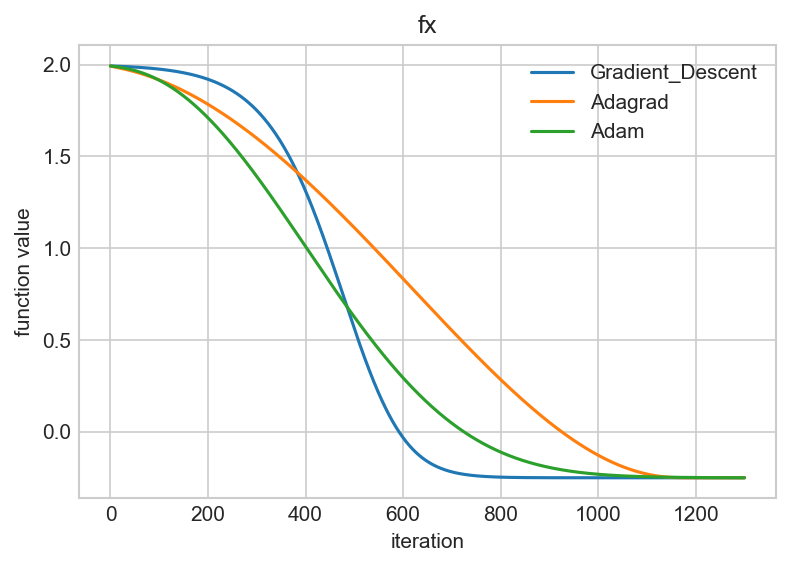

Gradient_Descent, basin, [ 0.044746 -0.039774], 0.003584, 1800
Adagrad, basin, [0.0005 0.0005], 0.000000, 1800
Adam, basin, [ 0.001564 -0.000253], 0.000003, 1800


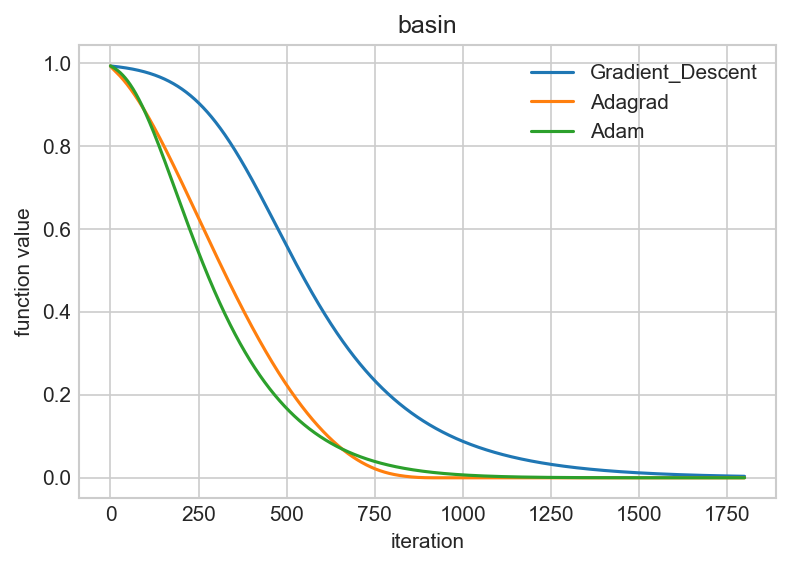

Gradient_Descent, rosenbrock, [1 1], 0.000000, 200
Adagrad, rosenbrock, [0 0], 1.000000, 200
Adam, rosenbrock, [0 0], 1.000000, 200


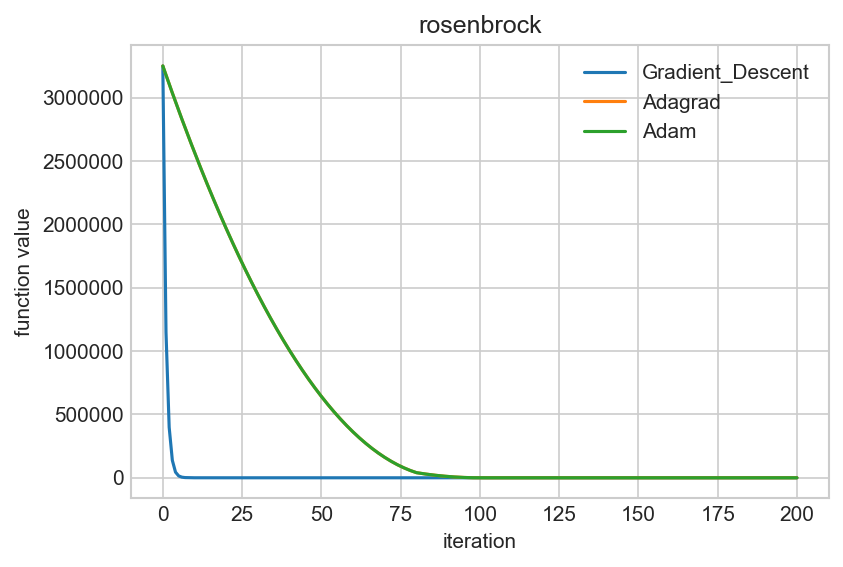

In [11]:
optimizers = [Gradient_Descent, Adagrad, Adam]
funcs = [fx,basin,rosenbrock]
funcs_lambda = [fx_lambda,basin_lambda,rosenbrock_lambda]
grads = [g_fx,g_basin,g_rosenbrock]
xs    = [fx_x,basin_x,rosenbrock_x]
xlims = [[-2, 2],[-3, 3],[-120, 120]]
ylims = [None,[-3, 3],[-120, 120]]
iters = [1300,1800,200]
skips = [5, 10, 1]
step_size = [0.01, 0.05, 5]

for func, func_lambda, x, g_func, iter_, xl, yl, step, skip in zip(funcs, funcs_lambda, xs, grads, iters, xlims, ylims, step_size, skips):
    fig, ax = plt.subplots(dpi=150)
    ax.set_title(str(func.__name__))
    ax.set_xlabel('iteration')
    ax.set_ylabel('function value')
    for opt_class in optimizers:
        opt = opt_class()
        final_x, xs, ys = minimize(x, g_func, iterations=iter_, optimizer=opt, f=func, return_seq=True, approximate_gradient=False)
        title_name = '_'.join(list(map(str, [type(opt).__name__, func.__name__])))
        print('{}, {}, {}, {:.6f}, {:d}'.format(str(type(opt).__name__), str(func.__name__), np.array2string(final_x, precision=6), ys[-1], iter_))
        visualize(title_name=title_name, filename=title_name+'.mp4', xs=xs, ys=ys, f=func_lambda, xlim=xl, ylim=yl, skip=skip, step=step)
        ax.plot(ys, label=str(type(opt).__name__))
    ax.legend(loc='upper right')
    plt.show()